In [1]:
%matplotlib widget

from pacti import write_contracts_to_file
from pacti.terms.polyhedra import PolyhedralContract
from pacti.iocontract import Var
from contract_utils import *
from plot_utils import plot_guarantees_with_bounds_hover

## Navigation viewpoint modeling

### Uncertainty-generating tasks (CHRG, DSN)

In [2]:
def uncertainty_generating_nav(s: int, noise: Tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",    # initial trajectory estimation uncertainty
      f"r{s}_entry",    # initial relative trajectory distance
    ],
    output_vars = [
      f"u{s}_exit",     # final trajectory estimation uncertainty
      f"r{s}_exit",     # final relative trajectory distance
    ],
    assumptions = [
      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",

      # 0 <= r{s}_entry <= 100
      f"-r{s}_entry <= 0",
      f" r{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # noise(min) <= u{exit} - u{entry} <= noise(max)
      f" u{s}_exit - u{s}_entry <=  {noise[1]}",
      f"-u{s}_exit + u{s}_entry <= -{noise[0]}",

      # no change to relative trajectory distance
      f"r{s}_exit - r{s}_entry = 0",
    ])
  return spec


### CHARGING Task

Objective: charge the spacecraft battery

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to the Sun injects a small disturbance that increases the trajectory estimation uncertainty.


In [3]:
charging1_nav = uncertainty_generating_nav(s=2, noise=(1.0, 1.1))
print(f"Contract charging1_nav:\n\n{charging1_nav}")

Contract charging1_nav:

InVars: [u2_entry, r2_entry]
OutVars:[u2_exit, r2_exit]
A: [
  -u2_entry <= -0
  u2_entry <= 100
  -r2_entry <= -0
  r2_entry <= 100
]
G: [
  u2_exit <= 100
  -u2_entry + u2_exit <= 1.1
  u2_entry - u2_exit <= -1
  -r2_entry + r2_exit = 0
]


### DSN Task

Objective: downlink science data to Earth.

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with a fixed impact:
- the spacecraft's attitude change to Earth injects a small disturbance that increases the trajectory estimation uncertainty.

In [4]:
dsn1_nav = uncertainty_generating_nav(s=1, noise=(1.1, 1.2))
print(f"Contract dsn1_nav:\n\n{dsn1_nav}")

Contract dsn1_nav:

InVars: [u1_entry, r1_entry]
OutVars:[u1_exit, r1_exit]
A: [
  -u1_entry <= -0
  u1_entry <= 100
  -r1_entry <= -0
  r1_entry <= 100
]
G: [
  u1_exit <= 100
  -u1_entry + u1_exit <= 1.2
  u1_entry - u1_exit <= -1.1
  -r1_entry + r1_exit = 0
]


### SBO Task

Objective: Acquire small body observations (science data & navigation)

As summarized in [the qualitative impacts table](#qualitative-impacts), this function affects this viewpoint with impacts that are linear with the duration of the task:
- the trajectory estimation error decreases proportionally to an improvement rate.

Note that this task has no impact on the relative trajectory progress.

Contract sbo1_nav:

InVars: [u3_entry, duration_sbo3]
OutVars:[u3_exit]
A: [
  -duration_sbo3 <= -0
  u3_entry <= 100
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0
  0.5 duration_sbo3 - u3_entry + u3_exit <= 0
  -u3_exit <= 0
]


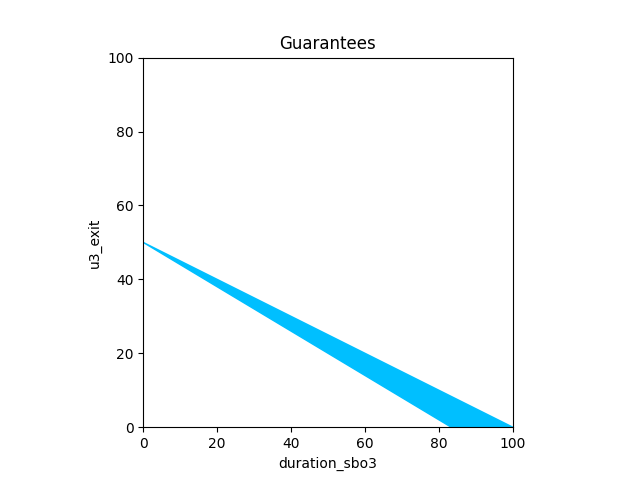

In [5]:
# Parameters:
# - s: start index of the timeline variables
# - improvement: rate of trajectory estimation uncertainty improvement during the task instance
def SBO_nav_uncertainty(s: int, improvement: Tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",      # initial trajectory uncertainty
      f"duration_sbo{s}", # knob variable for SBO duration
    ],
    output_vars = [
      f"u{s}_exit",       # final trajectory uncertainty
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_sbo{s} <= 0",

      # Upper-bound on the trajectory estimation uncertainty
      f"u{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # duration*improvement(min) <= u{entry} - u{exit} <= duration*improvement(max)
      f" u{s}_entry - u{s}_exit - {improvement[1]}*duration_sbo{s} <= 0",
      f"-u{s}_entry + u{s}_exit + {improvement[0]}*duration_sbo{s} <= 0",

      # Lower-bound on the trajectory estimation uncertainty
      f"-u{s}_exit <= 0",
    ])
  return spec

sbo1_nav_uncertainty = SBO_nav_uncertainty(s=3, improvement=(0.5, 0.6))
print(f"Contract sbo1_nav:\n\n{sbo1_nav_uncertainty}")

_ = plot_guarantees_with_bounds_hover(contract=sbo1_nav_uncertainty,
                x_var=Var("duration_sbo3"),
                y_var=Var("u3_exit"),
                var_values={
                  Var("u3_entry"):50,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [6]:
sbo1_nav_progress = nochange_contract(s=3, name="r")
print(f"sbo_nav_progress:\n{sbo1_nav_progress}")

sbo_nav_progress:
InVars: [r3_entry]
OutVars:[r3_exit]
A: [
  -r3_entry <= -0
]
G: [
  -r3_entry + r3_exit = 0
]


In [7]:
sbo1_nav = sbo1_nav_uncertainty.merge(sbo1_nav_progress)
print(f"sbo1_nav:\n{sbo1_nav}")

sbo1_nav:
InVars: [u3_entry, duration_sbo3, r3_entry]
OutVars:[u3_exit, r3_exit]
A: [
  -duration_sbo3 <= -0
  u3_entry <= 100
  -r3_entry <= -0
]
G: [
  -0.6 duration_sbo3 + u3_entry - u3_exit <= 0
  0.5 duration_sbo3 - u3_entry + u3_exit <= 0
  -u3_exit <= 0
  -r3_entry + r3_exit = 0
]


#### TCM Task (Perform a Trajectory Correction Maneuver)

Objective: Perform a delta-V maneuver to bring the spacecraft trajectory closer to that of the small body.

As described in [the qualitative impacts table](#qualitative-impacts), this function affects three viewpoints, each with impacts that are linear with the duration of the task:
- The navigation trajectory improves by a delta during the delta-V subtask.

Note: the heating subtask has no impact on navigation.

##### TCM Heating SubTask

Since TCM Heating has no impact on navigation, we use the no-change contract utility to specify this property for the two navigation viewpoint state variables: `u` and `r`.

In [8]:
tcm1_nav_heating = nochange_contract(s=4, name="u").merge(nochange_contract(s=4, name="r"))
print(f"sbo_nav_progress:\n{tcm1_nav_heating}")

sbo_nav_progress:
InVars: [u4_entry, r4_entry]
OutVars:[u4_exit, r4_exit]
A: [
  -u4_entry <= -0
  -r4_entry <= -0
]
G: [
  -u4_entry + u4_exit = 0
  -r4_entry + r4_exit = 0
]


##### TCM DeltaV SubTask

Contract tcm1_nav_deltav_uncertainty:

InVars: [u5_entry, duration_tcm_deltav5]
OutVars:[u5_exit]
A: [
  -duration_tcm_deltav5 <= -0
  -u5_entry <= -0
  u5_entry <= 100
]
G: [
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - u5_entry + u5_exit <= 0
  1.5 duration_tcm_deltav5 + u5_entry - u5_exit <= 0
]


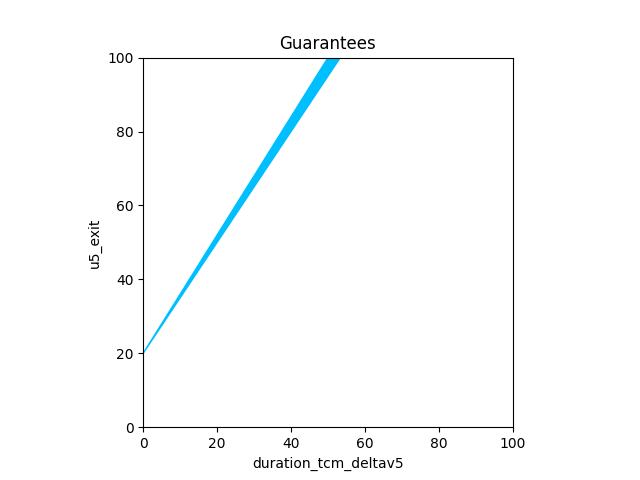

In [9]:
def TCM_navigation_deltav_uncertainty(s: int, noise: Tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"u{s}_entry",              # initial trajectory estimation uncertainty
      f"duration_tcm_deltav{s}",  # knob variable for TCM deltav duration

    ],
    output_vars = [
      f"u{s}_exit",               # final trajectory estimation uncertainty
    ],
    assumptions = [
      # Task has a positive scheduled duration
      f"-duration_tcm_deltav{s} <= 0",

      # 0 <= u{s}_entry <= 100
      f"-u{s}_entry <= 0",
      f" u{s}_entry <= 100",
    ],
    guarantees = [
      # upper bound u{s}_exit <= 100
      f"u{s}_exit <= 100",
      
      # noise(min) <= u{exit} - u{entry} <= noise(max)
      f" u{s}_exit - u{s}_entry - {noise[1]} duration_tcm_deltav{s} <= 0",
      f"-u{s}_exit + u{s}_entry + {noise[0]} duration_tcm_deltav{s} <= 0",
    ])
  return spec

tcm1_nav_deltav_uncertainty = TCM_navigation_deltav_uncertainty(s=5, noise=(1.5, 1.6))
print(f"Contract tcm1_nav_deltav_uncertainty:\n\n{tcm1_nav_deltav_uncertainty}")

_ = plot_guarantees_with_bounds_hover(contract=tcm1_nav_deltav_uncertainty,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("u5_exit"),
                var_values={
                  Var("u5_entry"):20,
                },
                x_lims=(0,100),
                y_lims=(0,100))

Contract tcm1_navigation_deltav_progress:

InVars: [r5_entry, duration_tcm_deltav5]
OutVars:[r5_exit]
A: [
  r5_entry <= 100
]
G: [
  -0.5 duration_tcm_deltav5 + r5_entry - r5_exit <= 0
  0.4 duration_tcm_deltav5 - r5_entry + r5_exit <= 0
  -r5_exit <= 0
]


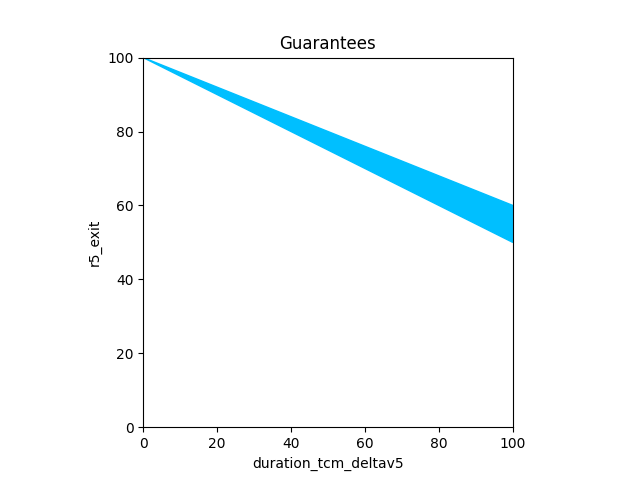

In [10]:
def TCM_navigation_deltav_progress(s: int, progress: Tuple[float, float]) -> PolyhedralContract:
  spec = PolyhedralContract.from_string(
    input_vars = [
      f"r{s}_entry",              # initial trajectory relative distance
      f"duration_tcm_deltav{s}",  # knob variable for TCM deltav duration
    ],
    output_vars = [
      f"r{s}_exit",               # final trajectory relative distance
    ],
    assumptions = [
      # upper bound on trajectory relative distance
      f"r{s}_entry <= 100",
    ],
    guarantees = [
      # duration*improvement(min) <= r{entry} - r{exit} <= duration*improvement(max)
      f" r{s}_entry - r{s}_exit - {progress[1]}*duration_tcm_deltav{s} <= 0",
      f"-r{s}_entry + r{s}_exit + {progress[0]}*duration_tcm_deltav{s} <= 0",

      # lower bound on trajectory relative distance
      f"-r{s}_exit <= 0",
    ])
  return spec

tcm1_nav_deltav_progress = TCM_navigation_deltav_progress(s=5, progress=(0.4, 0.5))
print(f"Contract tcm1_navigation_deltav_progress:\n\n{tcm1_nav_deltav_progress}")

_ = plot_guarantees_with_bounds_hover(contract=tcm1_nav_deltav_progress,
                x_var=Var("duration_tcm_deltav5"),
                y_var=Var("r5_exit"),
                var_values={
                  Var("r5_entry"):100,
                },
                x_lims=(0,100),
                y_lims=(0,100))

In [11]:
tcm1_nav_deltav = tcm1_nav_deltav_uncertainty.merge(tcm1_nav_deltav_progress)
print(f"Contract tcm1_nav_deltav:\n\n{tcm1_nav_deltav}")
print(tcm1_nav_deltav.get_variable_bounds("duration_tcm_deltav5"))

Contract tcm1_nav_deltav:

InVars: [u5_entry, duration_tcm_deltav5, r5_entry]
OutVars:[u5_exit, r5_exit]
A: [
  -duration_tcm_deltav5 <= -0
  -u5_entry <= -0
  u5_entry <= 100
  r5_entry <= 100
]
G: [
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - u5_entry + u5_exit <= 0
  1.5 duration_tcm_deltav5 + u5_entry - u5_exit <= 0
  -0.5 duration_tcm_deltav5 + r5_entry - r5_exit <= 0
  0.4 duration_tcm_deltav5 - r5_entry + r5_exit <= 0
  -r5_exit <= 0
]
(0.0, 66.66666666666667)


In [12]:
tcm1_nav = scenario_sequence(c1=tcm1_nav_heating, c2=tcm1_nav_deltav, variables=["u", "r"], c1index=4)
print(f"Contract tcm1_nav:\n\n{tcm1_nav}")
print(tcm1_nav.get_variable_bounds("duration_tcm_deltav5"))

Contract tcm1_nav:

InVars: [u4_entry, r4_entry, duration_tcm_deltav5]
OutVars:[u5_exit, r5_exit, output_u4, output_r4]
A: [
  -duration_tcm_deltav5 <= 0
  u4_entry <= 100
  r4_entry <= 100
  -u4_entry <= 0
  -r4_entry <= 0
]
G: [
  output_u4 - u4_entry = 0
  output_r4 - r4_entry = 0
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0
  0.4 duration_tcm_deltav5 - output_r4 + r5_exit <= 0
  -r5_exit <= 0
]
(0.0, 66.66666666666667)


### Navigation Schedule Analysis

Let's consider a simple 4-step schedule of the following sequence of task instances, which we compose:
- DSN
- CHARGING
- SBO
- TCM

In [13]:
steps12=scenario_sequence(c1=dsn1_nav, c2=charging1_nav, variables=["u", "r"], c1index=1)
print(f"---- L2R Steps 1,2\n{steps12}")
print('\n'.join(bounds(steps12)))

---- L2R Steps 1,2
InVars: [u1_entry, r1_entry]
OutVars:[u2_exit, r2_exit, output_u1, output_r1]
A: [
  -u1_entry <= 0
  u1_entry <= 100
  -r1_entry <= 0
  r1_entry <= 100
]
G: [
  output_u1 - u1_entry <= 1.2
  -output_u1 + u1_entry <= -1.1
  output_r1 - r1_entry = 0
  u2_exit <= 100
  -output_u1 + u2_exit <= 1.1
  output_u1 - u2_exit <= -1
  -output_r1 + r2_exit = 0
]
 input r1_entry in [0.00,100.00]
 input u1_entry in [0.00,97.90]
output output_r1 in [0.00,100.00]
output output_u1 in [1.10,99.00]
output r2_exit in [0.00,100.00]
output u2_exit in [2.10,100.00]


In [14]:
back34=scenario_sequence(c1=sbo1_nav, c2=tcm1_nav, variables=["u", "r"], c1index=3)
print(f"---- R2L Steps 3,4\n{back34}")
print('\n'.join(bounds(back34)))

---- R2L Steps 3,4
InVars: [u3_entry, duration_sbo3, r3_entry, duration_tcm_deltav5]
OutVars:[u5_exit, r5_exit, output_u4, output_r4, output_u3, output_r3]
A: [
  -duration_tcm_deltav5 <= 0
  r3_entry <= 100
  -duration_sbo3 <= 0
  u3_entry <= 100
  -r3_entry <= 0
]
G: [
  -0.6 duration_sbo3 - output_u3 + u3_entry <= 0
  0.5 duration_sbo3 + output_u3 - u3_entry <= 0
  -output_u3 <= 0
  output_r3 - r3_entry = 0
  -output_u3 + output_u4 = 0
  -output_r3 + output_r4 = 0
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0
  0.4 duration_tcm_deltav5 - output_r4 + r5_exit <= 0
  -r5_exit <= 0
]
 input duration_sbo3 in [0.00,200.00]
 input duration_tcm_deltav5 in [0.00,66.67]
 input r3_entry in [0.00,100.00]
 input u3_entry in [0.00,100.00]
output output_r3 in [0.00,100.00]
output output_r4 in [0.00,100.00]
output output_u3 in [0.00,100.00]
output output_u4 in [0.00

In [15]:
steps123=scenario_sequence(c1=steps12, c2=sbo1_nav, variables=["u", "r"], c1index=2)
print(f"---- L2R Steps 1,2,3\n{steps123}")
print('\n'.join(bounds(steps123)))

---- L2R Steps 1,2,3
InVars: [u1_entry, r1_entry, duration_sbo3]
OutVars:[output_u1, output_r1, u3_exit, r3_exit, output_u2, output_r2]
A: [
  -duration_sbo3 <= 0
  -u1_entry <= 0
  u1_entry <= 100
  -r1_entry <= 0
  r1_entry <= 100
]
G: [
  output_u1 - u1_entry <= 1.2
  -output_u1 + u1_entry <= -1.1
  output_r1 - r1_entry = 0
  output_u2 <= 100
  -output_u1 + output_u2 <= 1.1
  output_u1 - output_u2 <= -1
  -output_r1 + output_r2 = 0
  -0.6 duration_sbo3 + output_u2 - u3_exit <= 0
  0.5 duration_sbo3 - output_u2 + u3_exit <= 0
  -u3_exit <= 0
  -output_r2 + r3_exit = 0
]
 input duration_sbo3 in [0.00,200.00]
 input r1_entry in [0.00,100.00]
 input u1_entry in [0.00,97.90]
output output_r1 in [0.00,100.00]
output output_r2 in [0.00,100.00]
output output_u1 in [1.10,99.00]
output output_u2 in [2.10,100.00]
output r3_exit in [0.00,100.00]
output u3_exit in [0.00,100.00]


In [16]:
back234=scenario_sequence(c1=charging1_nav, c2=back34, variables=["u", "r"], c1index=2)
print(f"---- R2L Steps 2,3,4\n{back234}")
print('\n'.join(bounds(back234)))

---- R2L Steps 2,3,4
InVars: [u2_entry, r2_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[u5_exit, r5_exit, output_u4, output_r4, output_u3, output_r3, output_u2, output_r2]
A: [
  -duration_tcm_deltav5 <= 0
  -duration_sbo3 <= 0
  -u2_entry <= 0
  u2_entry <= 100
  -r2_entry <= 0
  r2_entry <= 100
]
G: [
  output_u2 <= 100
  output_u2 - u2_entry <= 1.1
  -output_u2 + u2_entry <= -1
  output_r2 - r2_entry = 0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0
  0.5 duration_sbo3 - output_u2 + output_u3 <= 0
  -output_u3 <= 0
  -output_r2 + output_r3 = 0
  -output_u3 + output_u4 = 0
  -output_r3 + output_r4 = 0
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0
  0.4 duration_tcm_deltav5 - output_r4 + r5_exit <= 0
  -r5_exit <= 0
]
 input duration_sbo3 in [0.00,200.00]
 input duration_tcm_deltav5 in [0.00,66.67]
 input r2_entry in [0.00,100.00]
 input u2

In [17]:
steps1234=scenario_sequence(c1=steps123, c2=tcm1_nav, variables=["u", "r"], c1index=3)
print(f"---- L2R Steps 1,2,3,4\n{steps1234}")

---- L2R Steps 1,2,3,4
InVars: [u1_entry, r1_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[output_u1, output_r1, output_u2, output_r2, u5_exit, r5_exit, output_u4, output_r4, output_u3, output_r3]
A: [
  -duration_tcm_deltav5 <= 0
  -duration_sbo3 <= 0
  -u1_entry <= 0
  u1_entry <= 100
  -r1_entry <= 0
  r1_entry <= 100
]
G: [
  output_u1 - u1_entry <= 1.2
  -output_u1 + u1_entry <= -1.1
  output_r1 - r1_entry = 0
  output_u2 <= 100
  -output_u1 + output_u2 <= 1.1
  output_u1 - output_u2 <= -1
  -output_r1 + output_r2 = 0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0
  0.5 duration_sbo3 - output_u2 + output_u3 <= 0
  -output_u3 <= 0
  -output_r2 + output_r3 = 0
  -output_u3 + output_u4 = 0
  -output_r3 + output_r4 = 0
  u5_exit <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + u5_exit <= 0
  1.5 duration_tcm_deltav5 + output_u4 - u5_exit <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - r5_exit <= 0
  0.4 duration_tcm_deltav5 - output_r4 + r5_exit <= 0
  -r5_exit <= 0
]


In [18]:
scenario_nav=steps1234.rename_variables([
    ("u4_exit", "output_u4"), 
    ("r4_exit", "output_r4"),
    ("u5_exit", "output_u5"), 
    ("r5_exit", "output_r5")])
print(f"scenario_nav={scenario_nav}")
print('\n'.join(bounds(scenario_nav)))

scenario_nav=InVars: [u1_entry, r1_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[output_u1, output_r1, output_u2, output_r2, output_u4, output_r4, output_u3, output_r3, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0
  -duration_sbo3 <= 0
  -u1_entry <= 0
  u1_entry <= 100
  -r1_entry <= 0
  r1_entry <= 100
]
G: [
  output_u1 - u1_entry <= 1.2
  -output_u1 + u1_entry <= -1.1
  output_r1 - r1_entry = 0
  output_u2 <= 100
  -output_u1 + output_u2 <= 1.1
  output_u1 - output_u2 <= -1
  -output_r1 + output_r2 = 0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0
  0.5 duration_sbo3 - output_u2 + output_u3 <= 0
  -output_u3 <= 0
  -output_r2 + output_r3 = 0
  -output_u3 + output_u4 = 0
  -output_r3 + output_r4 = 0
  output_u5 <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + output_u5 <= 0
  1.5 duration_tcm_deltav5 + output_u4 - output_u5 <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - output_r5 <= 0
  0.4 duration_tcm_deltav5 - output_r4 + output_r5 <= 0
  -output_r5 <= 0
]
 

In [19]:
back1234=scenario_sequence(c1=dsn1_nav, c2=back234, variables=["u", "r"], c1index=1).rename_variables([("u5_exit", "output_u5"),("r5_exit", "output_r5")])
print(f"---- R2L Steps 1,2,3,4\n{back1234}")
print('\n'.join(bounds(back1234)))

---- R2L Steps 1,2,3,4
InVars: [u1_entry, r1_entry, duration_sbo3, duration_tcm_deltav5]
OutVars:[output_u4, output_r4, output_u3, output_r3, output_u2, output_r2, output_u1, output_r1, output_u5, output_r5]
A: [
  -duration_tcm_deltav5 <= 0
  -duration_sbo3 <= 0
  -u1_entry <= 0
  u1_entry <= 100
  -r1_entry <= 0
  r1_entry <= 100
]
G: [
  output_u1 - u1_entry <= 1.2
  -output_u1 + u1_entry <= -1.1
  output_r1 - r1_entry = 0
  output_u2 <= 100
  -output_u1 + output_u2 <= 1.1
  output_u1 - output_u2 <= -1
  -output_r1 + output_r2 = 0
  -0.6 duration_sbo3 + output_u2 - output_u3 <= 0
  0.5 duration_sbo3 - output_u2 + output_u3 <= 0
  -output_u3 <= 0
  -output_r2 + output_r3 = 0
  -output_u3 + output_u4 = 0
  -output_r3 + output_r4 = 0
  output_u5 <= 100
  -1.6 duration_tcm_deltav5 - output_u4 + output_u5 <= 0
  1.5 duration_tcm_deltav5 + output_u4 - output_u5 <= 0
  -0.5 duration_tcm_deltav5 + output_r4 - output_r5 <= 0
  0.4 duration_tcm_deltav5 - output_r4 + output_r5 <= 0
  -output_r

In [20]:
write_contracts_to_file(contracts=[scenario_nav, back1234], 
                        names=["scenario_nav_l2r", "scenario_nav_r2l"], 
                        file_name="json/scenario_nav.json")